In [1]:
%pylab inline

from xgboost.sklearn import XGBClassifier
from typing import Tuple
import xgboost as xgb
import pandas as pd
import json 
import sklearn

dataset = pd.read_csv('data/multisession-eeg.csv')
fromstring = lambda array_str: np.fromstring(array_str, dtype=float, sep=',')
dataset.raw_fft = dataset.raw_fft.apply(fromstring)
# dataset.raw_fft.iloc[0]

Populating the interactive namespace from numpy and matplotlib


# Passthoughts

What if you could simply *think your password*? That's the premise behind *passthoughts*. We'll discuss passthoughts in more depth in lecture 3, but for now, we'll lay this out as a classification problem:

> Given a reading, and a person, is that person who they claim to be?

We'll structure this problem as follows: For each subject, we'll train a classifier. That subject's readings will be positive example, and everyone else's readings will be negative examples.

We can make this a little fancier by having people use specific thoughts (e.g. "focus on your breathing," "sing a song in your head," etc). We'll make sure our methods can handle this case, but for the time being, we'll just use the `"unabeled"` readings - people doing nothing in particular.

We'll use subject `A` as our "target" individual. We will train on this subject for this assignment, and train against the other subjects in the corpus (subjects `B` and `C`).

In [4]:
def to_matrix (series):
    return np.array([ x for x in series ])

def readings_right_subject_right_task (subj, task, session=0):
    return to_matrix(dataset[
        (dataset['subject'] == subj) &
        (dataset['label'] == task) &
        (dataset['session'] == session)
    ].raw_fft)

def readings_wrong_subj_any_task (subj):
    return to_matrix(dataset[
        (dataset['subject'] != subj)
    ].raw_fft)

In [5]:
dataset['label'].unique()

array(['unlabeled', 'breathe', 'song', 'song_o', 'sport', 'breathe_o',
       'speech', 'face', 'calibration', 'word_x', 'phrase_x', 'face_x',
       'breatheopen', 'song_x', 'sport_x', 'breatheclosed', 'word_c',
       'phrase_c', 'face_c', 'song_c', 'sport_c'], dtype=object)

In [6]:
positive = readings_right_subject_right_task('A', 'unlabeled', 0)
negative = readings_wrong_subj_any_task('A')
positive.shape, positive.shape

((40, 516), (40, 516))

## TODO

Notice how we structured our positive and negative examples:

- *Positive examples*: The right person thinking the right task.

- *Negative examples*: The wrong person thinking any task (whether it is right or wrong).

In the context of passthoughts, consider other possibilites for selecting positive and negative features. Here, (1) pick one configuration of positive and negative examples, aside from the ones listed, and (2) discuss their possible consequences (pros/cons). Explain how you might evaluate this selection (with data, with user experiments, etc - your choice).

## Answer

Another possible configuration:
* _Positive examples_: The right person thinking the right task
* _Negative examples_: The right person thinking the wrong task & The wrong person thinking any task

**Pros**: It is complete, meaning that the classifier trained on this configuration has defined behavior for any input data.

**Cons**: It could be harder to train since now the classifier needs to distinguish between the same person thinking about different tasks, which is presumably harder than distinguishing between different persons.

**Evaluation**: For evaluation, we can use same approach as we evaluate the original configuration.

Now, we'll turn these data into our feature/label matrices `X` and `y`.

In [7]:
X = np.concatenate([positive, negative])

In [8]:
y = np.array([ 0 for x in positive] + [ 1 for x in negative])
assert X.shape[0] == y.shape[0]

Note that we are assigning `0` to "positive" examples, and `1` to "negative" examples. That means `0` will mean "ACCEPT" and `1` will mean "REJECT."

## TODO

Now, train and test a classifier! Estimate your classifier's accuracy.

In [9]:
def fresh_clf () -> XGBClassifier:
    return XGBClassifier(
        # Don't worry about those parameters for now,
        # though feel free to look them up if you're interested.
        objective= 'binary:logistic',
        seed=27)

def xgb_cross_validate (
    X: np.array,
    y: np.array,
    nfold: int=7
) -> Tuple[XGBClassifier, pd.DataFrame]:
    # eval_metrics:
    # http://xgboost.readthedocs.io/en/latest//parameter.html
    metrics = ['error@0.1', 'auc']
#     metrics = [ 'auc' ]
    # we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
    # the intent here to to minimize FAR at the expense of FRR
    alg = fresh_clf()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=100
                      )
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

In [10]:
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)

In [11]:
clf.score(X_validate, y_validate)

0.98329355608591884

For authentication, what we want even more than "accuracy" here are two metrics:

- False Acceptance Rate (FAR): The percentage of readings *not* from subject A incorrectly classified "ACCEPT."
- False Rejection Rate (FRR): The percentage of readings *from* subject A incorrectly classified 'REJECT."

For authentication /security/, we want FAR to be as low as possible (so nobody can break in).
For authentication /usability/, we want FRR to be low (so user's don't get frustrated constantly re-trying their passthought).

In [12]:
def far_frr (classifier, features, labels):
    # predict all the labels
    y_pred = classifier.predict(features)
    false_accepts = 0
    false_rejects = 0
    for predicted, actual in zip(y_pred, labels):
        # if we should have rejected,
        # but in fact accepted,
        if (actual == 1) and (predicted == 0):
            # increment false accepts
            false_accepts += 1
        # if we should have accepted,
        # but in fact rejected,
        if (actual == 0) and (predicted == 1):
            # increment false rejections
            false_rejects += 1
    # calculate proportions for each
    far = false_accepts / len(list(filter(lambda x: x==0, y_pred)))
    frr = false_rejects / len(list(filter(lambda x: x==1, y_pred)))
    return far, frr

In [15]:
far, frr = far_frr(clf, X_validate, y_validate)
print('FAR: {} - FRR: {}'.format(far, frr))

FAR: 0.3 - FRR: 0.009779951100244499


Now, these results might be good. 

But our classifier's accuracy could be misleading.   

Can you see why? 

# Nonstationarity

We are training, and testing, using data recorded over a single session. As we know, EEG changes over time, a property known as *nonstationarity*. Will our great results still hold a few weeks later?

Let's take subject `A`'s data from sessions 1 and 2, which were recorded a few weeks after session 0.

In [33]:
X_subja_sess1 = readings_right_subject_right_task('A', 'unlabeled', 1)
X_subja_sess2 = readings_right_subject_right_task('A', 'unlabeled', 2)
X_subja_later = np.concatenate([X_subja_sess1, X_subja_sess2])
y_subja_later = [0 for x in X_subja_later]

Now, let's try the classifier we trained on the original data, testing it on the later data.

In [34]:
far, frr = far_frr(clf, X_subja_later, y_subja_later)
print('FAR: {} - FRR: {}'.format(far, frr))

FAR: 0.0 - FRR: 1.0


In [35]:
clf.score(X_subja_later, y_subja_later)

0.15097402597402598

As we will discuss more in lecture 3, this is a problem for us. After all, we can calibrate our target subject, but we then expect them to leave the lab and go use the device later on. If their state changes so much that they can no longer be authenticated, we can't very well claim our system is accurate!

## TODO

The crux of the lab focuses on nonstationarity. At minimum, your mission is to quantify and qualify *what* is changing in EEG signals over time. You may use any tools in answering this question.

You also have your choice of corpus:

- Study subject `A`'s recordings over the three sessions provided here.
- Study one subject's recordings over the course of a year.

You can use both of these corpora, if you would like.

Some questions to spur investigation:

- What features of readings cause a classifier that works on earlier recordings fail on later ones?
- What features remain the same? Are there any?
- What might be the source of these changing features? Changing placement in the EEG device? Changing properties of the brain?

Please note below all work you do, and any notes you make along the way. Ideally, your work should read like a story - words (and questions!) interspersed with code. Good luck, and have fun!

## Answer

I'll focus on subject A's recordings over sessions 0, 1 and 2. First, we examine which features are important for classifier to make a decision. We can either plot out the *feature\_importances\_* attribute of xgboost model or we can use the handy built-in *plot\_importance* function to do the sorting job for us.

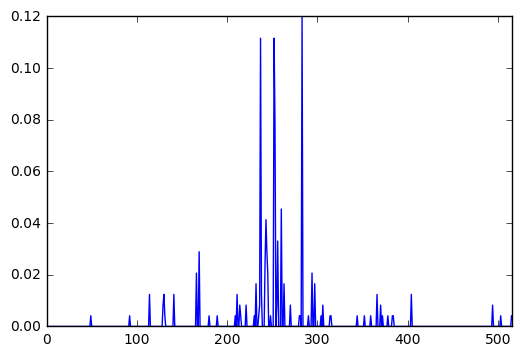

In [48]:
pd.Series(clf.feature_importances_).plot()

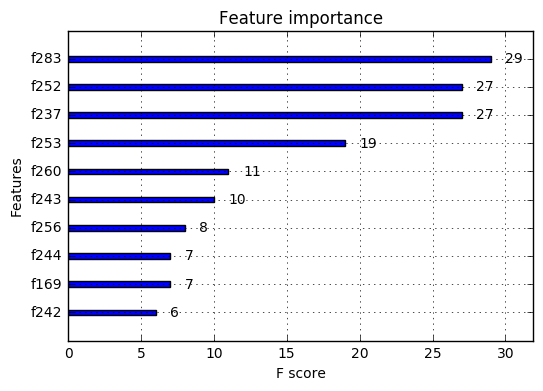

In [51]:
from matplotlib import pyplot as plt
from xgboost import plot_importance
plot_importance(clf, max_num_features=10)

The first figure would give us a general sense of what frequencies are important for our classifier. The second figure lists top 10 most important features. We can roughly make out two important ranges from this figure, from 242 to 244 and from 252 to 256. Next, we'll compute some basic statistics of these features and compare them across sessions.